In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")
%matplotlib inline
import datetime as dt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("Data/Sales Transaction v.4a.csv")
#df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


# Preprocessing

In [ ]:
# BASIC EXPLORATION
print("Number of rows in dataset is: ", df.shape[0])
print("Number of columns in dataset is: ", df.shape[1])

Number of rows in dataset is:  536350
Number of columns in dataset is:  8


In [ ]:
df.describe()

,Price,Quantity,CustomerNo
count,536350.000000,536350.000000,536295.000000
mean,12.662182,9.919347,15227.893178
std,8.490450,216.662300,1716.582932
min,5.130000,-80995.000000,12004.000000
25%,10.990000,1.000000,13807.000000
50%,11.940000,3.000000,15152.000000
75%,14.090000,10.000000,16729.000000
max,660.620000,80995.000000,18287.000000


In [ ]:
#Filtering transaction with invoice number started with letter 'C' (canceled transaction)
cancelled = df[df['TransactionNo'].astype(str).str.contains('C')]
cancelled.head()


,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
1616,C581484,12/9/2019,23843,Paper Craft Little Birdie,6.19,-80995,16446.0,United Kingdom
1617,C581490,12/9/2019,22178,Victorian Glass Hanging T-Light,6.19,-12,14397.0,United Kingdom
1618,C581490,12/9/2019,23144,Zinc T-Light Holder Stars Small,6.04,-11,14397.0,United Kingdom
1619,C581568,12/9/2019,21258,Victorian Sewing Box Large,6.19,-5,15311.0,United Kingdom
1620,C581569,12/9/2019,84978,Hanging Heart Jar T-Light Holder,6.19,-1,17315.0,United Kingdom


In [ ]:
print("Number of canceled transactions:", len(cancelled))
print("Total number of transaction with negative quantity:", df[df['Quantity'] <= 0 ]['Quantity'].count())

Number of canceled transactions: 8585
Total number of transaction with negative quantity: 8585


In [ ]:
df[df['Quantity'] == 0].head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country


In [ ]:
print("Total number of transaction with zero quantity:", df[df['Quantity'] == 0 ]['Quantity'].count())

Total number of transaction with zero quantity: 0


In [ ]:
df[df['Price'] <= 0].head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country


In [ ]:
print("Total number of transaction with negative price:", df[df['Price'] <= 0 ]['Price'].count())

Total number of transaction with negative price: 0


In [ ]:
print("Percentage of cancelled transactions:" , round(len(cancelled)/len(df)*100, 2),"%")
print("Precentage of transactions with zero or negative price" ,round(len(df[df['Price']<=0])/len(df)*100, 2),"%")

Percentage of cancelled transactions: 1.6 %
Precentage of transactions with zero or negative price 0.0 %


In [ ]:
data = df[df['Quantity']>0] # loai bo cac giao dich co so luong am
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527765 entries, 0 to 536324
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  527765 non-null  object 
 1   Date           527765 non-null  object 
 2   ProductNo      527765 non-null  object 
 3   ProductName    527765 non-null  object 
 4   Price          527765 non-null  float64
 5   Quantity       527765 non-null  int64  
 6   CustomerNo     527764 non-null  float64
 7   Country        527765 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.2+ MB


In [ ]:
# Check Null value
data.isnull().sum()

TransactionNo    0
Date             0
ProductNo        0
ProductName      0
Price            0
Quantity         0
CustomerNo       1
Country          0
dtype: int64

In [ ]:
# Drop rows with missing CustomerNo
data = data.dropna(subset=['CustomerNo'])

In [ ]:
data.isnull().sum()

TransactionNo    0
Date             0
ProductNo        0
ProductName      0
Price            0
Quantity         0
CustomerNo       0
Country          0
dtype: int64

In [ ]:
# Check duplicate transactions
print("Number of duplicated transactions:", len(data[data.duplicated()]))

Number of duplicated transactions: 5163


In [ ]:
# Delete duplicate transactions
data.drop_duplicates(inplace = True)

In [ ]:
# Convert Date DataType to Datetime
dateFormat = '%m/%d/%Y'
data['Date'] = pd.to_datetime(data['Date'],format = dateFormat)
data.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom


In [ ]:
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year
data['month_year'] = pd.to_datetime(data[['year', 'month']].assign(Day=1))
data.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,month,year,month_year
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,12,2019,2019-12-01
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,12,2019,2019-12-01
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,12,2019,2019-12-01
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,12,2019,2019-12-01
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,12,2019,2019-12-01


In [ ]:
data['TotalMoney'] = data['Price'] * data['Quantity']
data.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,month,year,month_year,TotalMoney
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,12,2019,2019-12-01,257.64
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,12,2019,2019-12-01,383.40
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,12,2019,2019-12-01,138.36
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,12,2019,2019-12-01,127.80
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,12,2019,2019-12-01,71.64


In [ ]:
# Check rows and columns of data
print("Number of rows in processed data is: ", data.shape[0])
print("Number of columns in processed data is: ", data.shape[1])

Number of rows in processed data is:  522601
Number of columns in processed data is:  12


In [ ]:
unique_transaction = len(pd.unique(data['TransactionNo']))

print("No.of.unique TransactionNo:", unique_transaction)

No.of.unique TransactionNo: 19789


In [ ]:
unique_procduct = len(pd.unique(data['ProductName']))
print("No.of.unique Product:", unique_procduct)

No.of.unique Product: 3753


# EDA

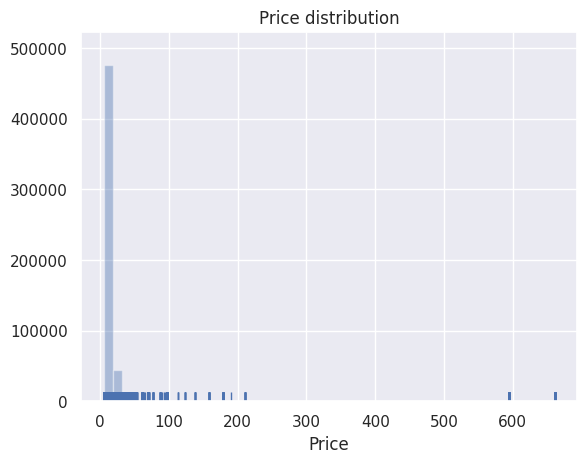

In [ ]:
# Price  distribution
sns.distplot(data['Price'], kde=False, rug=True)
plt.title("Price distribution")
plt.show()

In [ ]:
# Price Statistics
data['Price'].describe()

count    522601.000000
mean         12.637160
std           7.965974
min           5.130000
25%          10.990000
50%          11.940000
75%          14.090000
max         660.620000
Name: Price, dtype: float64

In [ ]:
print("Transactions were made in", len(data['Country'].unique().tolist()), "different countries")

Transactions were made in 38 different countries


In [ ]:
print("Number of transactions where country is unspecified:", len(data[data['Country']=='Unspecified']))

Number of transactions where country is unspecified: 443


In [ ]:
pd.DataFrame(data['Quantity'].describe()).T

,count,mean,std,min,25%,50%,75%,max
Quantity,522601.0,10.667492,157.54242,1.0,1.0,4.0,12.0,80995.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f18375bd370>,
 'caps': [<matplotlib.lines.Line2D at 0x7f18375bd8b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f18375bd0d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f18375bddf0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f18375cf0d0>],
 'means': []}

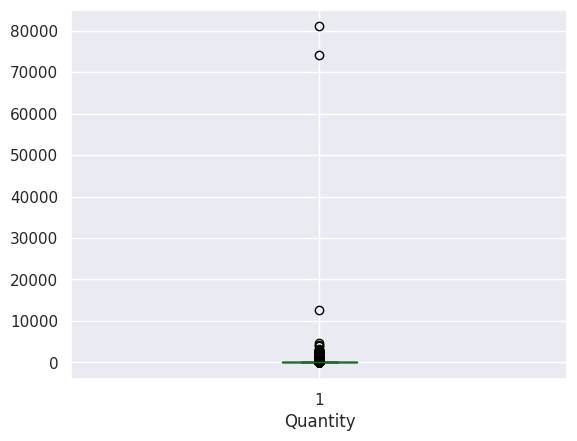

In [ ]:
plt.figure()
sns.set_palette(['green'])
plt.tight_layout()
plt.gca().set(xlabel= 'Quantity', ylabel='')
plt.boxplot(data['Quantity'])

** How many orders per month? **



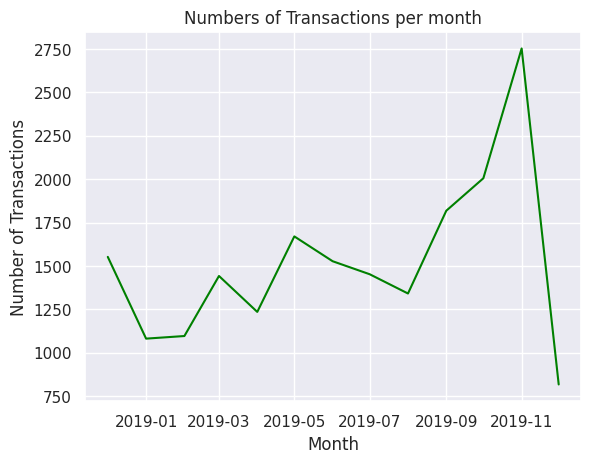

In [ ]:
# How many orders per month?
#plot = pd.DataFrame(data.groupby(['month_year'])['TransactionNo'].count()).reset_index()
plot = data.groupby(by = ["month_year"]).agg({"TransactionNo": "nunique"})
ax = sns.lineplot(x="month_year", y="TransactionNo", data = plot, palette='mako')
plt.title("Numbers of Transactions per month")
plt.ylabel("Number of Transactions")
plt.xlabel("Month")
plt.show()

Có nhiều giao dịch được thực hiện vào cuối năm. Số lượng giao dịch cao nhất được thực hiện trong tháng 11. Có lẽ lý do có thể là mọi người có xu hướng chuẩn bị cho Giáng sinh trong tháng mười một hoặc chuẩn bị đoán năm mới vào tháng 1. Khác với số lượng mua hàng ở tháng mười một, trong khoảng thời gian còn lại số lượng mua hàng hóa ở các tháng tương tựa nhau.

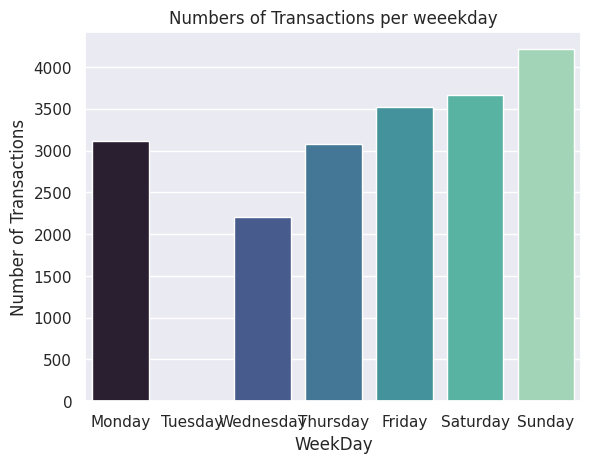

In [ ]:
# How many orders per day?
data['WeekDay'] = data['Date'].dt.day_name()
#plot2 = pd.DataFrame(data.groupby(['WeekDay'])['TransactionNo'].count())
plot2= data.groupby(by = ["WeekDay"]).agg({"TransactionNo": "nunique"})
plot2 = plot2.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index()
ax = sns.barplot(x="WeekDay", y="TransactionNo", data = plot2, palette='mako')
plt.title("Numbers of Transactions per weeekday")
plt.ylabel("Number of Transactions")
plt.xlabel("WeekDay")
plt.show()

Không có bất kỳ giao dịch nào vào thứ ba trong toàn bộ thời gian. Có thể vì một số bộ lọc trong quá trình thu thập dữ liệu hoặc Số lượng mua không khác biệt đáng kể theo ngày trong tuần.

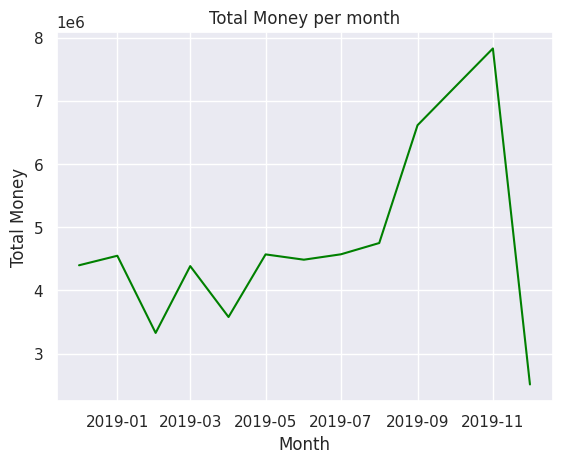

In [ ]:
# Which month brings the highest revenue?
plot4 = pd.DataFrame(data.groupby(['month_year'])['TotalMoney'].sum()).reset_index()
ax = sns.lineplot(x = 'month_year', y='TotalMoney', data = plot4, palette='mako')
plt.title("Total Money per month")
plt.ylabel("Total Money")
plt.xlabel("Month")
plt.show()

In [ ]:
# Explore by month
gp_month = data.sort_values('Date').groupby(['year', 'month'])
gp_month_frq_amount= gp_month['TransactionNo'].agg(np.size)
gp_month_frq_amount

year  month
2018  12       40899
2019  1        33860
      2        26759
      3        35318
      4        28707
      5        35756
      6        35533
      7        38138
      8        34092
      9        48635
      10       58269
      11       81819
      12       24816
Name: TransactionNo, dtype: int64

In [ ]:
gp_month = data.sort_values('Date').groupby(['year', 'month'])
gp_month_frq_amount= gp_month['TotalMoney'].agg(np.sum)
gp_month_frq_amount

year  month
2018  12       4397648.39
2019  1        4548423.47
      2        3327342.64
      3        4384669.82
      4        3579310.06
      5        4569952.21
      6        4486050.15
      7        4571494.88
      8        4749801.23
      9        6613772.79
      10       7212279.85
      11       7828489.53
      12       2512069.52
Name: TotalMoney, dtype: float64

In [ ]:
# *Price
pd.DataFrame(data['Price'].describe()).T

,count,mean,std,min,25%,50%,75%,max
Price,522601.0,12.63716,7.965974,5.13,10.99,11.94,14.09,660.62


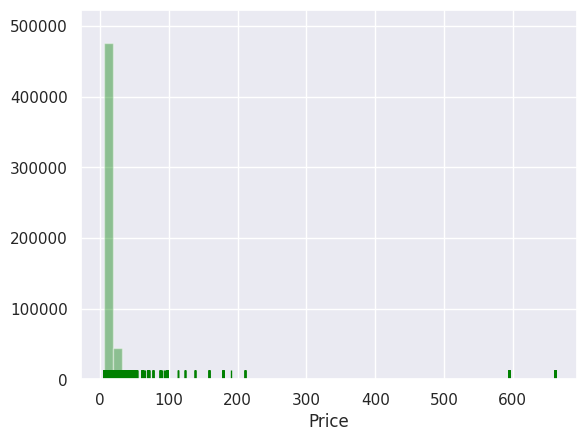

In [ ]:
sns.distplot(data['Price'], kde=False, rug=True);

In [ ]:
#data[data['Price']>50]['ProductName'].unique().tolist()

**Transaction**

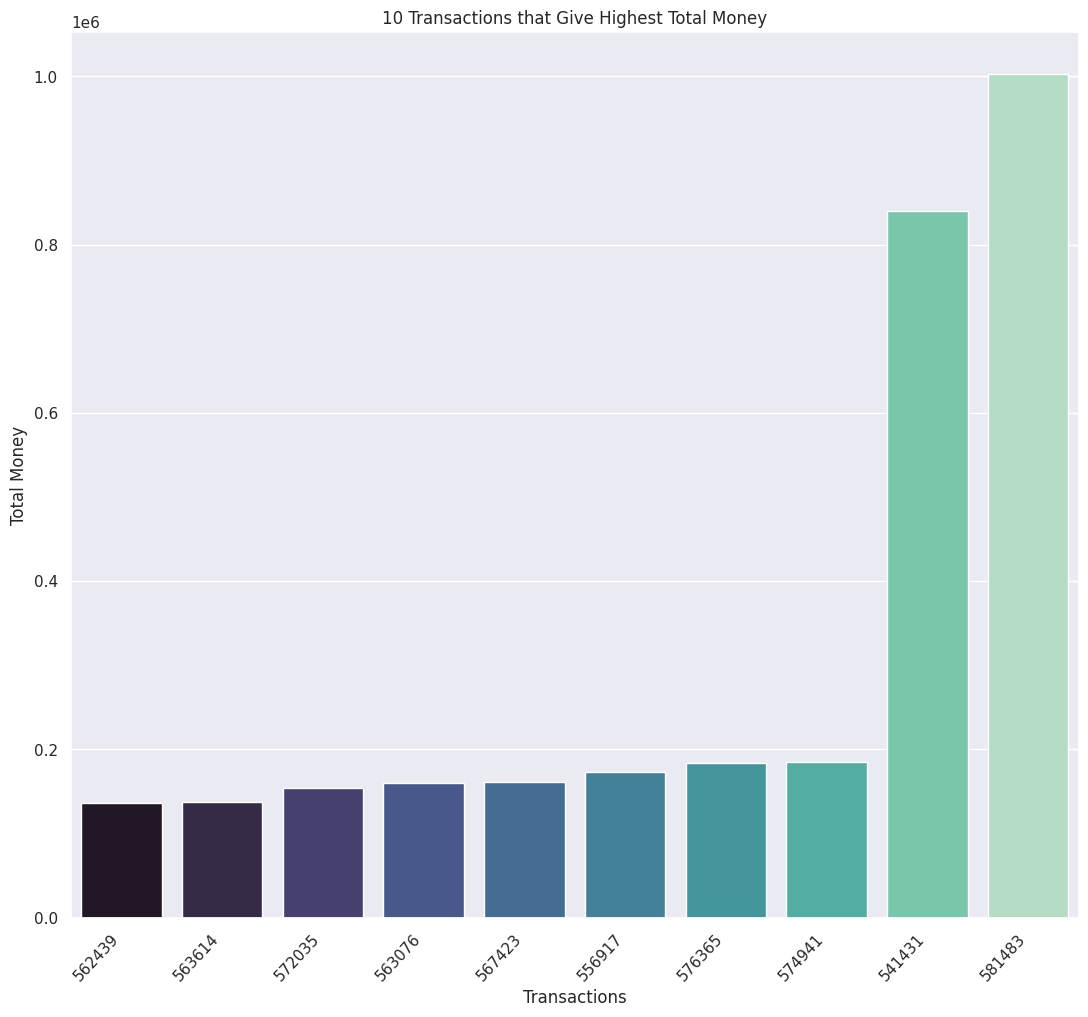

In [ ]:
plot5 = pd.DataFrame(data.groupby(['TransactionNo'])['TotalMoney'].sum()).reset_index()
plot5 = plot5.sort_values(['TotalMoney']).reset_index(drop=True)
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(13, 11.5)
ax=sns.barplot(x='TransactionNo', y='TotalMoney',data=plot5.tail(10),estimator=max,ax=ax, palette='mako')
ax.set_xticklabels(ax.get_xticklabels(), rotation=47, ha="right")
plt.title("10 Transactions that Give Highest Total Money")
plt.xlabel("Transactions")
plt.ylabel("Total Money")
plt.show()

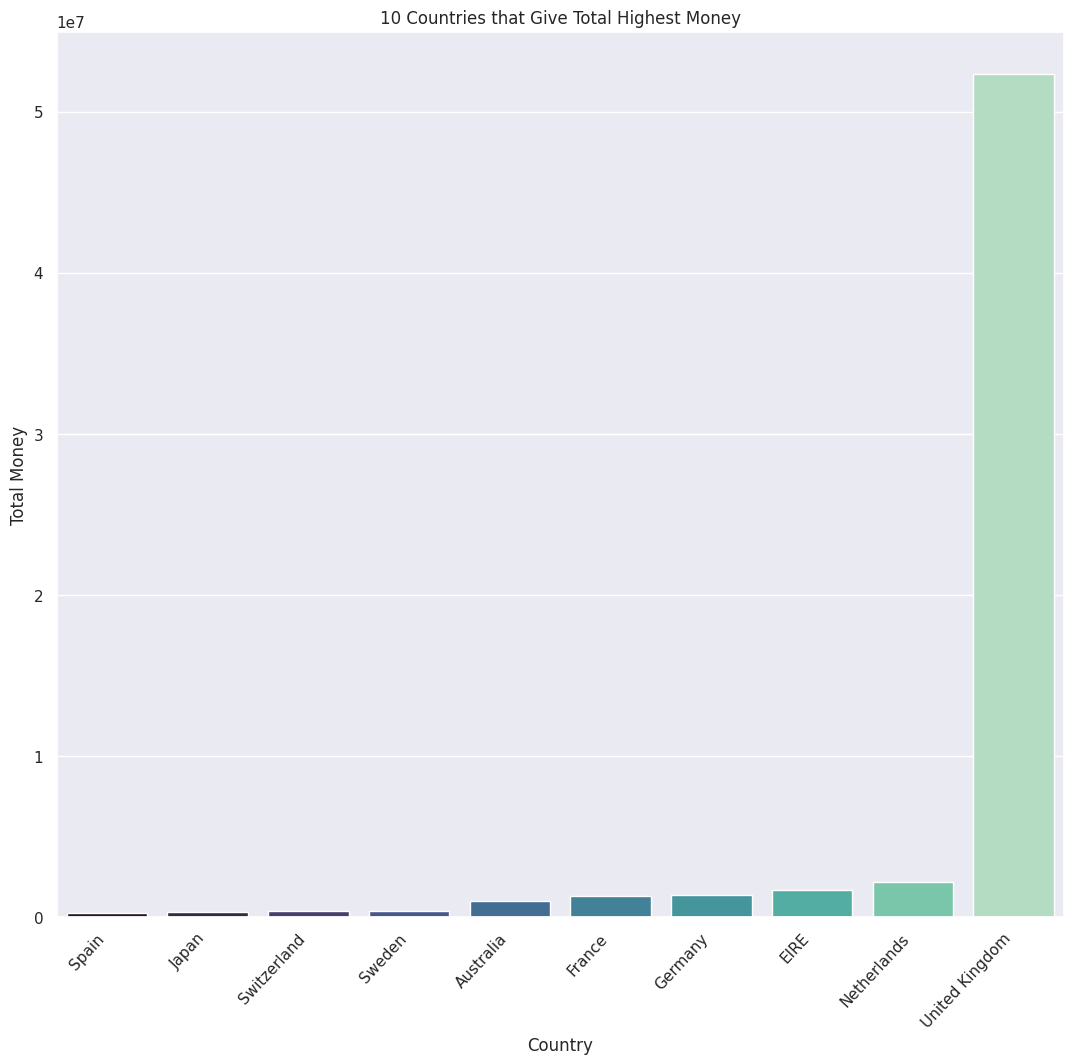

In [ ]:
plot6 = pd.DataFrame(data.groupby(['Country'])['TotalMoney'].sum()).reset_index()
plot6 = plot6.sort_values(['TotalMoney']).reset_index(drop=True)
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(13, 11.5)
ax=sns.barplot(x='Country', y='TotalMoney',data=plot6.tail(10),estimator=max,ax=ax, palette='mako')
ax.set_xticklabels(ax.get_xticklabels(), rotation=47, ha="right")
plt.title("10 Countries that Give Total Highest Money")
plt.ylabel("Total Money")
plt.xlabel("Country")
plt.show()

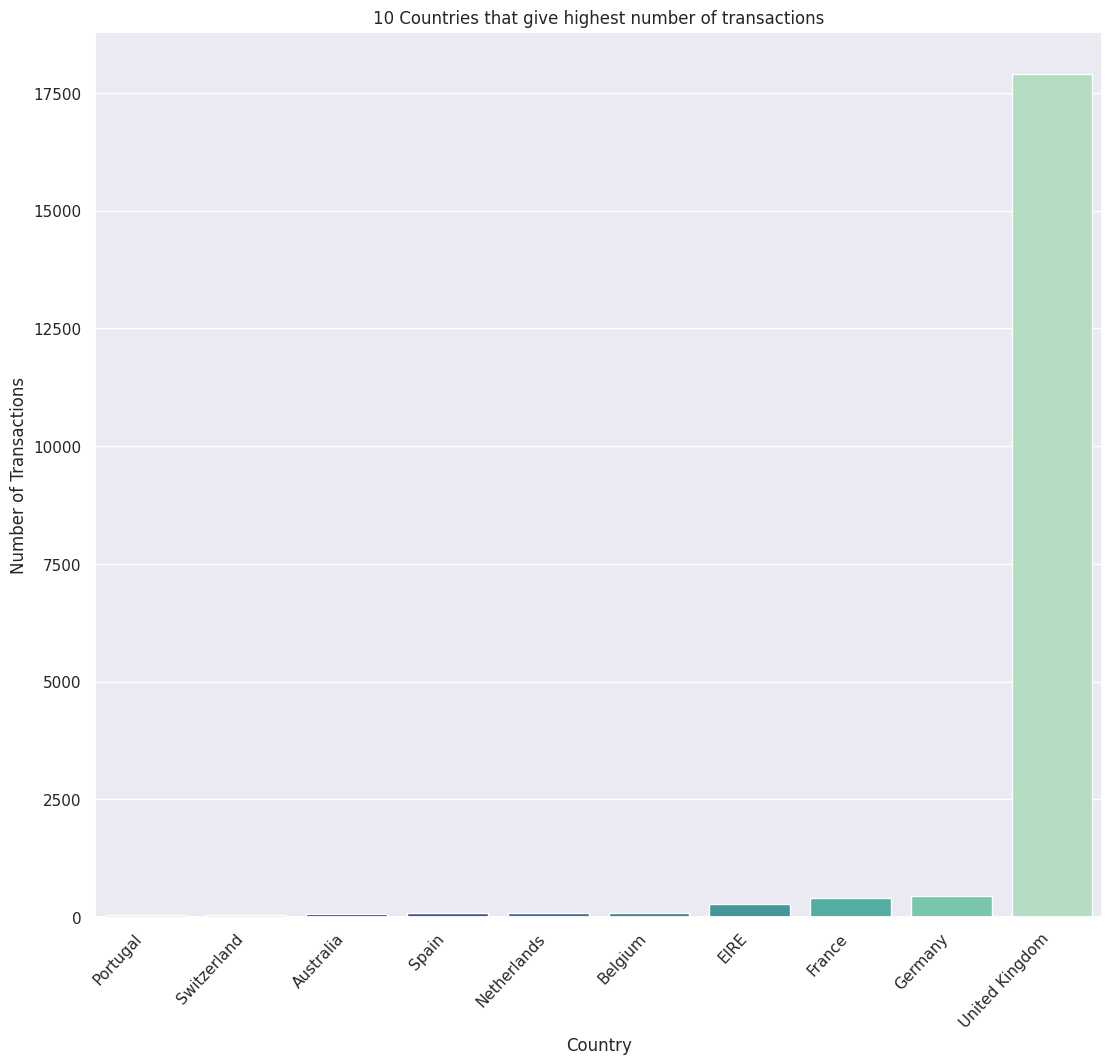

In [ ]:
#plot7 = pd.DataFrame(data.groupby(['Country'])['TransactionNo'].count()).reset_index()
plot7 = data.groupby(by = ["Country"]).agg({"TransactionNo": "nunique"}).reset_index()
plot7 = plot7.sort_values(['TransactionNo']).reset_index(drop=True)
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(13, 11.5)
ax=sns.barplot(x='Country', y='TransactionNo',data=plot7.tail(10),estimator=max,ax=ax, palette = 'mako')
ax.set_xticklabels(ax.get_xticklabels(), rotation=47, ha="right")
plt.title("10 Countries that give highest number of transactions")
plt.ylabel("Number of Transactions")
plt.xlabel("Country")
plt.show()

Danh sách các quốc gia có khách hàng mua hàng nhiều nhất dựa vào doanh thu

In [ ]:
data['freq'] = data.groupby('CustomerNo')['CustomerNo'].transform('count')

In [ ]:
customer  = pd.DataFrame(data.groupby(['CustomerNo'])['TotalMoney'].sum().sort_values(ascending=False)).reset_index().head(10)

In [ ]:
top_customer = data[data['CustomerNo'].isin(customer['CustomerNo'].tolist())][['CustomerNo', 'Country', 'TotalMoney', 'Quantity', 'freq']]

In [ ]:
top_customer['Country'].unique().tolist()

['United Kingdom', 'Netherlands', 'EIRE', 'Australia']

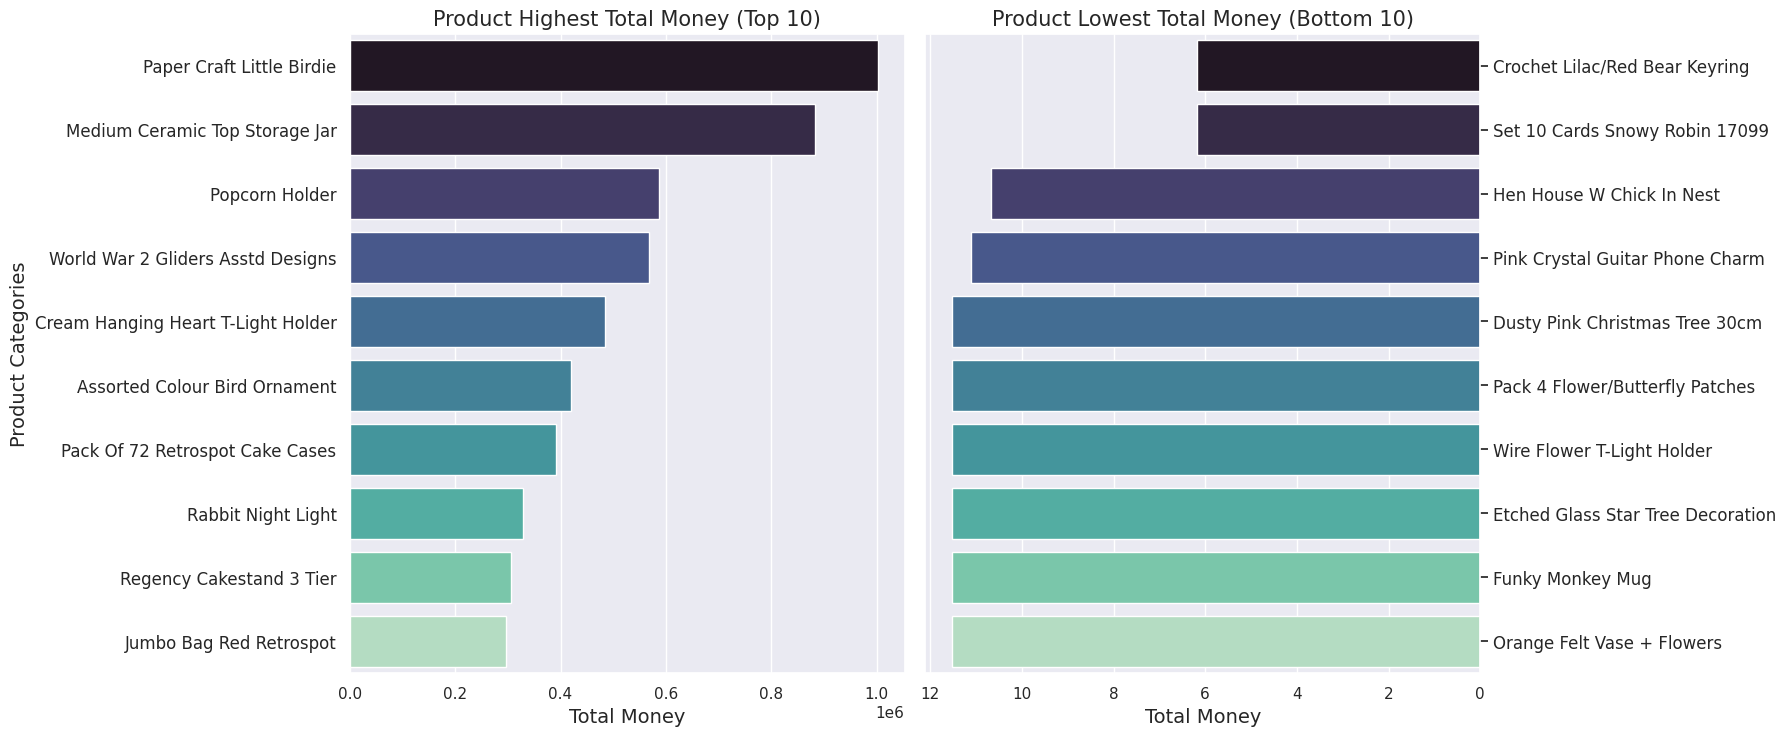

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 7.5))

prodCat_TopRevenue = data.groupby(data['ProductName'])['TotalMoney'].sum().reset_index().sort_values('TotalMoney', ascending = False)
sns.barplot(x = 'TotalMoney', y = 'ProductName', data = prodCat_TopRevenue[:10], palette = 'mako', ax = ax[0])
ax[0].set_xlabel("Total Money", fontsize = 14)
ax[0].set_ylabel("Product Categories", fontsize = 14)
ax[0].tick_params(axis = 'y', labelsize = 12)
ax[0].set_title("Product Highest Total Money (Top 10)", fontsize = 15)

prodCat_BotRevenue = data.groupby(data['ProductName'])['TotalMoney'].sum().reset_index().sort_values('TotalMoney', ascending = True)
sns.barplot(x = 'TotalMoney', y = 'ProductName', data = prodCat_BotRevenue[:10], palette = 'mako', ax = ax[1])
ax[1].set_xlabel("Total Money", fontsize = 14)
ax[1].set_ylabel("")
ax[1].invert_xaxis()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].tick_params(axis = 'y', labelsize = 12)
ax[1].set_title("Product Lowest Total Money (Bottom 10)", fontsize = 15)

plt.tight_layout(pad = 1)
plt.show()

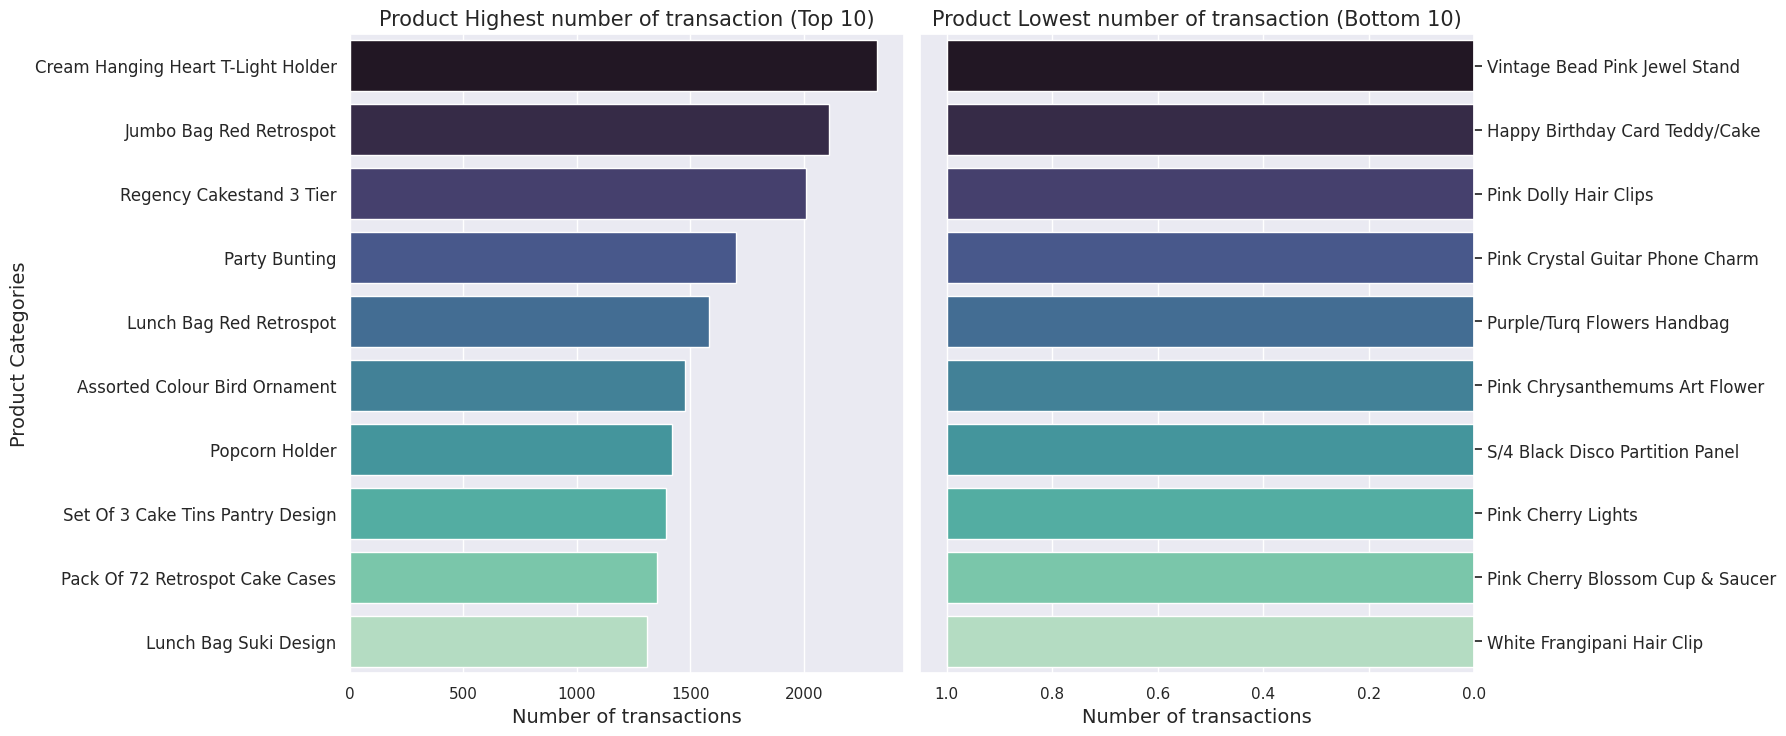

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 7.5))

prodCat_TopRevenue = data.groupby(data['ProductName'])['TransactionNo'].count().reset_index().sort_values('TransactionNo', ascending = False)
sns.barplot(x = 'TransactionNo', y = 'ProductName', data = prodCat_TopRevenue[:10], palette = 'mako', ax = ax[0])
ax[0].set_xlabel("Number of transactions", fontsize = 14)
ax[0].set_ylabel("Product Categories", fontsize = 14)
ax[0].tick_params(axis = 'y', labelsize = 12)
ax[0].set_title("Product Highest number of transaction (Top 10)", fontsize = 15)

prodCat_BotRevenue = data.groupby(data['ProductName'])['TransactionNo'].count().reset_index().sort_values('TransactionNo', ascending = True)
sns.barplot(x = 'TransactionNo', y = 'ProductName', data = prodCat_BotRevenue[:10], palette = 'mako', ax = ax[1])
ax[1].set_xlabel("Number of transactions", fontsize = 14)
ax[1].set_ylabel("")
ax[1].invert_xaxis()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].tick_params(axis = 'y', labelsize = 12)
ax[1].set_title("Product Lowest number of transaction (Bottom 10)", fontsize = 15)

plt.tight_layout(pad = 1)
plt.show()

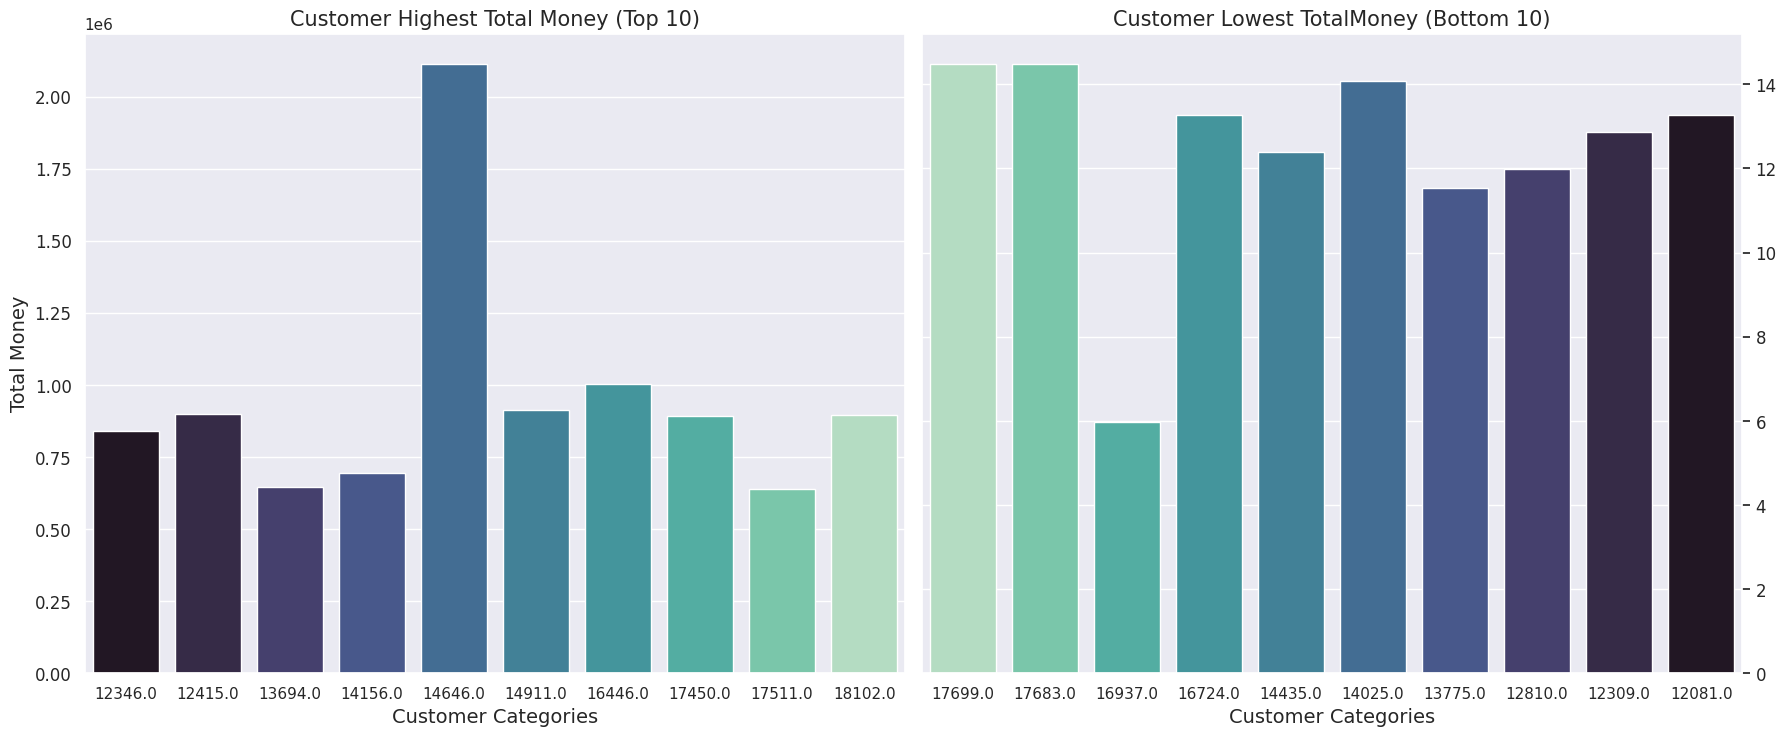

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 7.5))

prodCat_TopRevenue = data.groupby(data['CustomerNo'])['TotalMoney'].sum().reset_index().sort_values('TotalMoney', ascending = False)
sns.barplot(x = 'CustomerNo', y = 'TotalMoney', data = prodCat_TopRevenue[:10], palette = 'mako', ax = ax[0])
ax[0].set_xlabel("Customer Categories", fontsize = 14)
ax[0].set_ylabel("Total Money", fontsize = 14)
ax[0].tick_params(axis = 'y', labelsize = 12)
ax[0].set_title("Customer Highest Total Money (Top 10)", fontsize = 15)


prodCat_BotRevenue = data.groupby(data['CustomerNo'])['TotalMoney'].sum().reset_index().sort_values('TotalMoney', ascending = True)
sns.barplot(x = 'CustomerNo', y = 'TotalMoney', data = prodCat_BotRevenue[:10], palette = 'mako', ax = ax[1])
ax[1].set_xlabel("Customer Categories", fontsize = 14)
ax[1].set_ylabel("")
ax[1].invert_xaxis()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].tick_params(axis = 'y', labelsize = 12)
ax[1].set_title("Customer Lowest TotalMoney (Bottom 10)", fontsize = 15)


plt.tight_layout(pad = 1)
plt.show()

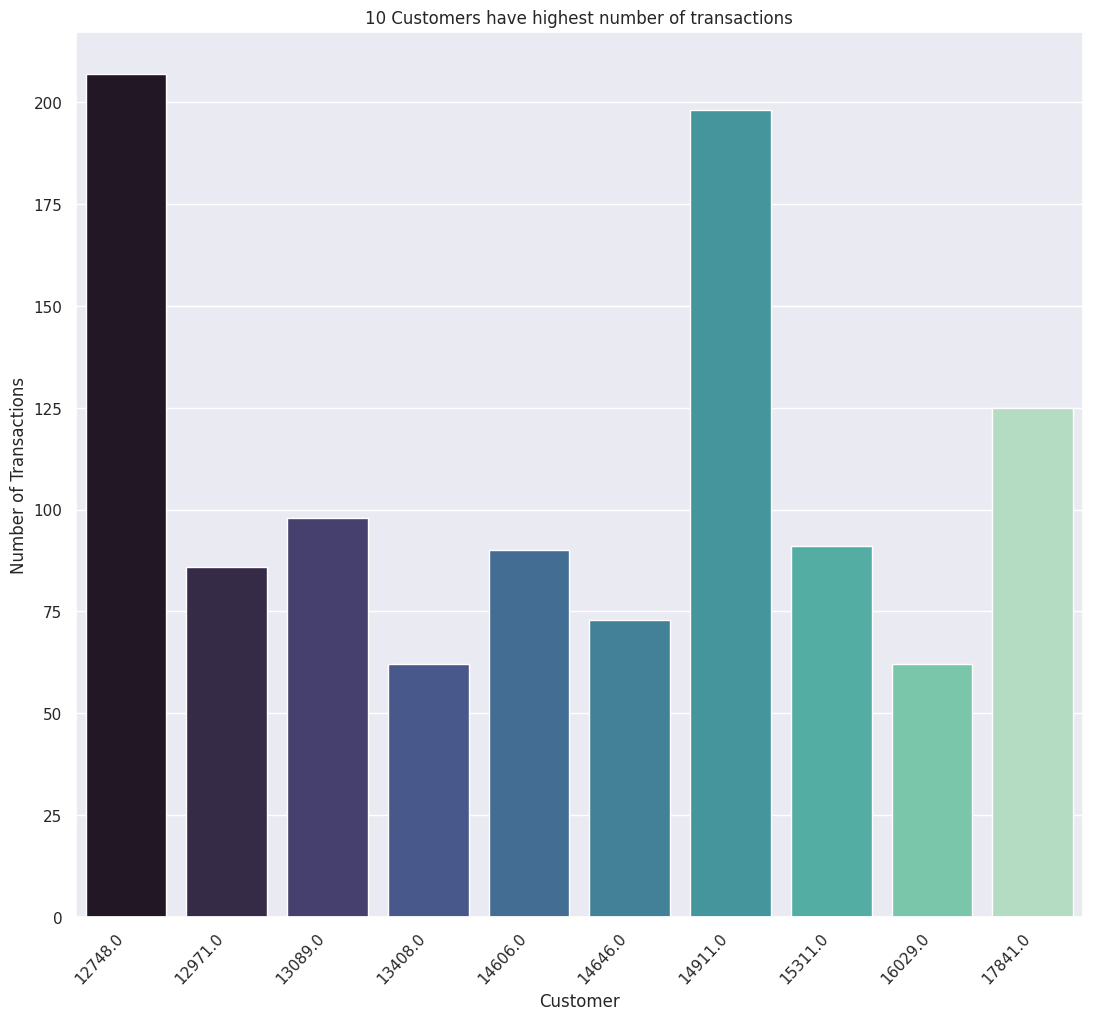

In [ ]:
#plot8 = pd.DataFrame(data.groupby(['CustomerNo'])['TransactionNo'].count()).reset_index()
plot8 = data.groupby(by = ["CustomerNo"]).agg({"TransactionNo": "nunique"}).reset_index()
plot8 = plot8.sort_values(['TransactionNo']).reset_index(drop=True)
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(13, 11.5)
ax=sns.barplot(x='CustomerNo', y='TransactionNo',data=plot8.tail(10),estimator=max,ax=ax, palette = 'mako')
ax.set_xticklabels(ax.get_xticklabels(), rotation=47, ha="right")
plt.title("10 Customers have highest number of transactions")
plt.ylabel("Number of Transactions")
plt.xlabel("Customer")
plt.show()

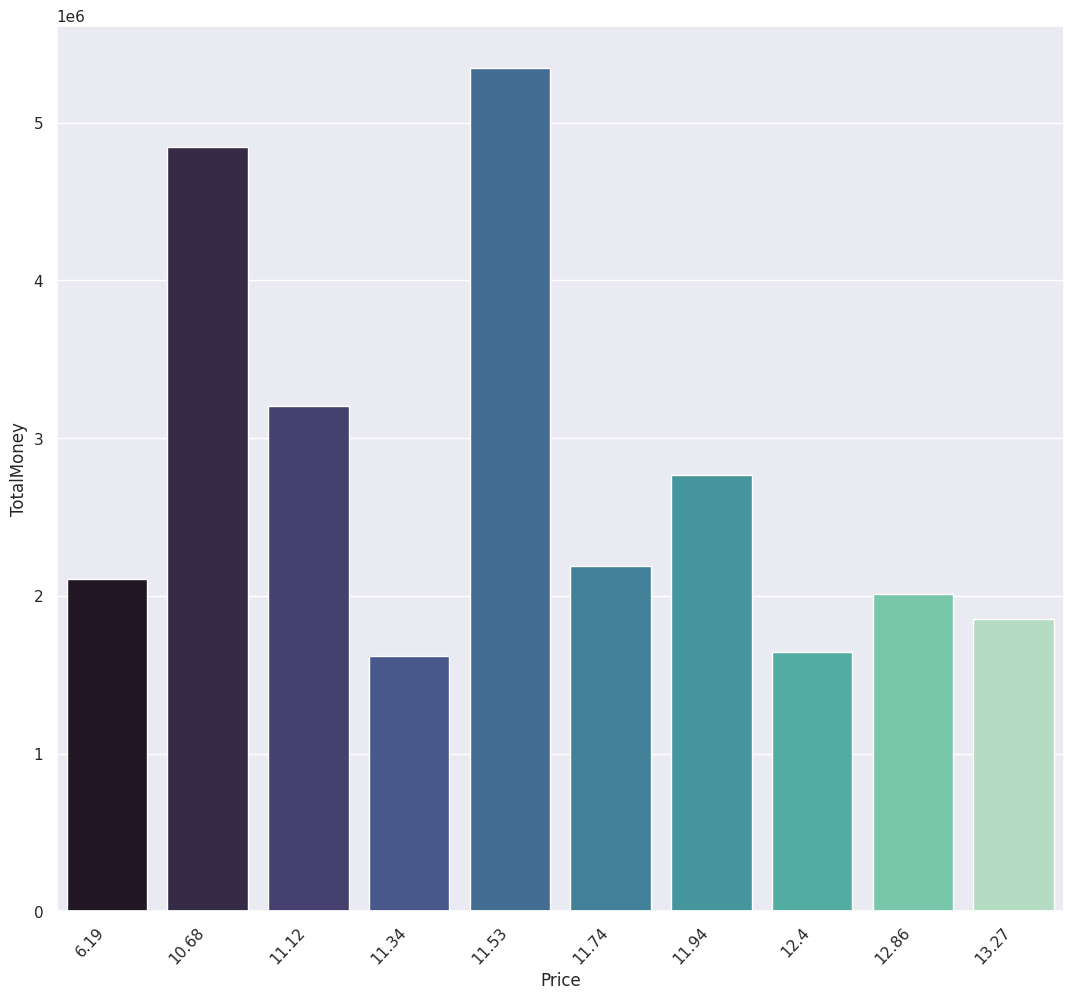

In [ ]:
plot9 = pd.DataFrame(data.groupby(['Price'])['TotalMoney'].sum()).reset_index()
plot9 = plot9.sort_values(['TotalMoney']).reset_index(drop=True)
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(13, 11.5)
ax=sns.barplot(x='Price', y='TotalMoney',data=plot9.tail(10),estimator=max,ax=ax, palette = 'mako')
ax.set_xticklabels(ax.get_xticklabels(), rotation=47, ha="right")
plt.show()

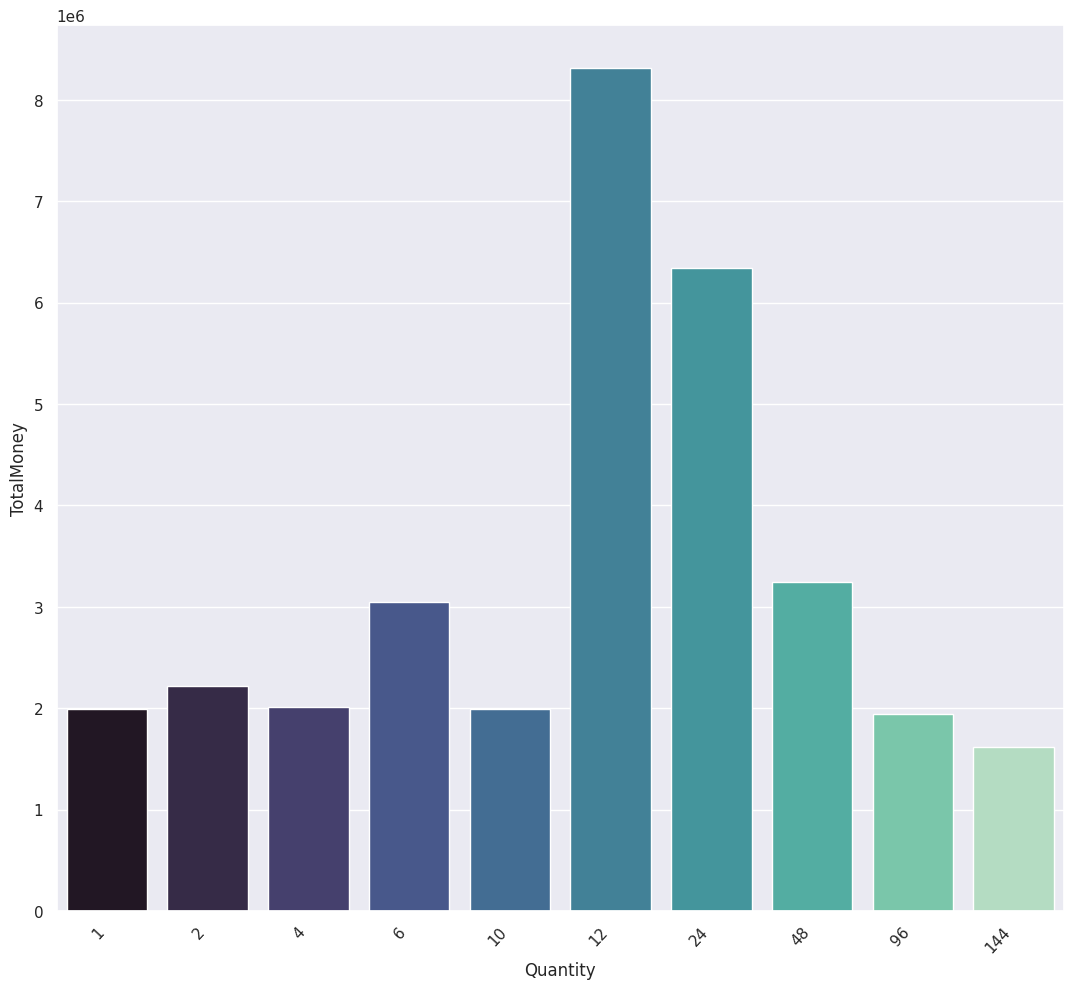

In [ ]:
plot10 = pd.DataFrame(data.groupby(['Quantity'])['TotalMoney'].sum()).reset_index()
plot10 = plot10.sort_values(['TotalMoney']).reset_index(drop=True)
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(13, 11.5)
ax=sns.barplot(x='Quantity', y='TotalMoney',data=plot10.tail(10),estimator=max,ax=ax, palette = 'mako')
ax.set_xticklabels(ax.get_xticklabels(), rotation=47, ha="right")
plt.show()